### Discovery of interesting peak-gene pairs

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 
import anndata as ad
import requests

In [3]:
# load data
rna_adata = ad.read_h5ad('./data/rna.h5ad')
atac_adata = ad.read_h5ad('./data/atac.h5ad')
atac_adata.var.index = atac_adata.var.index.map(lambda peak: peak[9:])
atac_adata.var.index.name = 'Peak'
gene_locations = pd.read_table('./data/gene_locations_hg38.tsv', index_col = 'Gene ID', usecols = ['Gene ID', 'Begin', 'End', 'Chromosome', 'Symbol', 'Gene Type', 'Accession'])
gene_locations.drop(index = [idx for idx, accession in gene_locations['Accession'].items() if not accession.startswith('NC')], inplace = True)

In [194]:
new_gene_locs = gene_locations.copy()
new_gene_locs.index = new_gene_locs['Symbol']
gene_to_idx = {
  gene: new_gene_locs.loc[gene] for gene in rna_adata.var['gene'].unique() if gene in new_gene_locs.index and len(new_gene_locs.loc[gene].shape) == 1
}

In [ ]:
gene_to_peaks_map = {
  gene: atac_adata.var_names[(atac_adata.var['Chr'] == f'chr{row['Chromosome']}') & 
                             (atac_adata.var['End'] >= row['Begin'] - 1.5 * 10 ** 5) & 
                             (atac_adata.var['Start'] <= row['End'] + 1.5 * 10 ** 5)]
  for gene, row in gene_to_idx.items()
}

#### Prior knowledge validation

Based on prior heart studies in mice, we expect to see:
- Periostin (Postn) expression to increase with TAC and decrease with TAC+JQ1
- MEOX1 expression to increase with TAC and decrease with TAC+JQ1
- MEOX1 peaks to increase with TAC and decrease with TAC+JQ1
  - This data is human so peaks will likely not be 1:1 with mice data

In [4]:
palette = {'Unstim': '#2ca02c', 'TGFb': '#d62728', 'TGFb+JQ1': '#1f77b4'}
markers = {'Lung': 'o', 'Heart': '^', 'Liver': 's'}

diverging_palette = 'vlag'
hue_norm = lambda: mpl.colors.SymLogNorm(1)
sm = lambda hnorm: plt.cm.ScalarMappable(cmap=diverging_palette, norm=hnorm)

In [5]:
# boxplot of expression over organ/condition
def plot_expression(adata: ad.AnnData, gene: str, layer: str = None, **kwargs) -> plt.Axes:
  gene_rna_adata = adata[:, adata.var['gene'] == gene]
  ax = sns.boxplot(gene_rna_adata.obs, x = 'organ', y = gene_rna_adata.to_df(layer = layer).sum(axis = 1), order=markers.keys(), hue = 'condition', palette=palette, hue_order = palette.keys(), **kwargs)
  ax.set_ylabel(f'{gene} expression {layer if layer is not None else ""}')
  return ax

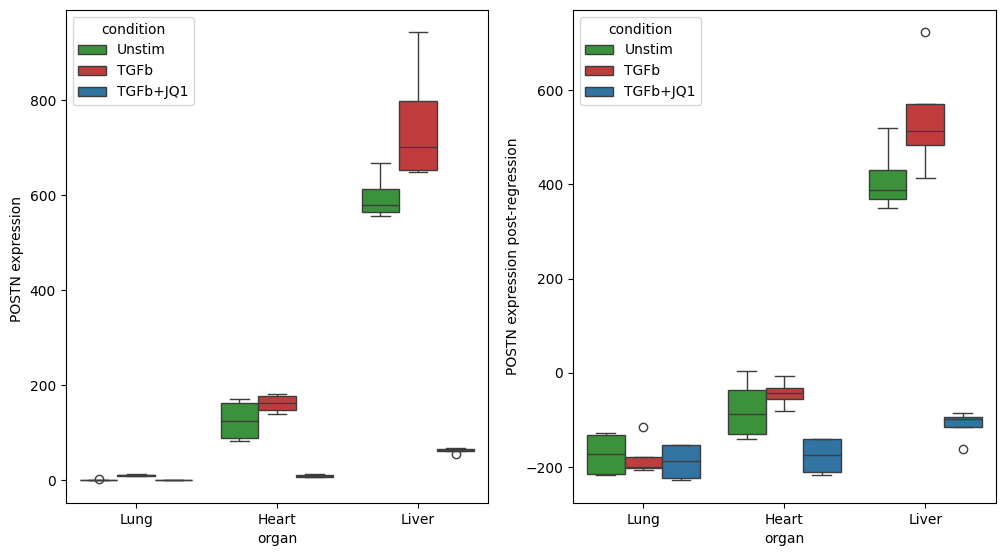

In [6]:
# Periostin expression pre- and post-regression
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_expression(rna_adata, gene = 'POSTN', ax=ax1)
plot_expression(rna_adata, gene = 'POSTN', layer = 'post-regression', ax=ax2)
plt.show()

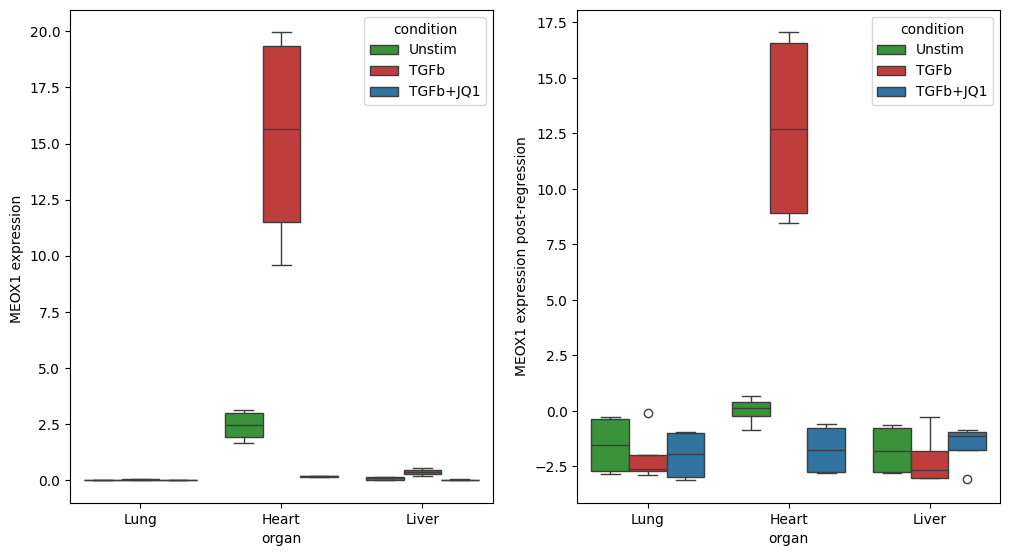

In [7]:
# MEOX1 expression
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_expression(rna_adata, gene = 'MEOX1', ax=ax1)
plot_expression(rna_adata, gene = 'MEOX1', layer = 'post-regression', ax=ax2)
plt.show()

In [246]:
# heatmap of atac peaks over location range. also boxes the (approximate) gene location
def plot_peak_range(adata: ad.AnnData, gene: str, layer: str = None, **kwargs) -> plt.Axes:
  peak_adata = adata[:, gene_to_peaks_map[gene]]
  peak_heatmap_df = pd.DataFrame({
    f"{organ}-{condition}": {
      peak: np.mean(peak_adata[rows.index, peak]._get_X(layer = layer)) for peak in peak_adata.var_names
    }
    for (organ, condition), rows in peak_adata.obs.groupby(['organ', 'condition'])
  }, dtype = 'float64')
  peak_heatmap_df = peak_heatmap_df[[f"{organ}-{condition}" for organ in markers.keys() for condition in palette.keys()]]
  ax = sns.heatmap(peak_heatmap_df, cmap = 'viridis', **kwargs)
  ax.set_ylabel("Peak")
  ax.set_xlabel("Organ-Condition")
  ax.set_title(f"Peaks around {gene}")
  loc_info = gene_to_idx[gene]
  coding_index = peak_adata[:, (peak_adata.var['End'] >= loc_info['Begin']) & (peak_adata.var['Start'] <= loc_info['End'])].var_names
  ax.add_patch(plt.Rectangle((0, peak_heatmap_df.index.get_loc(coding_index[0])), len(peak_heatmap_df.columns), len(coding_index), fill=False, edgecolor='crimson', lw=2, clip_on=False))
  return ax

In [9]:
meox1_row = gene_locations[gene_locations['Symbol'] == 'MEOX1']
meox1_row

,Accession,Begin,End,Chromosome,Symbol,Gene Type
Gene ID,,,,,,
4222,NC_000017.11,43640389,43661922,17,MEOX1,protein-coding


/scratch/ipykernel_2875337/1623660810.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (organ, condition), rows in peak_adata.obs.groupby(['organ', 'condition'])
/scratch/ipykernel_2875337/1623660810.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (organ, condition), rows in peak_adata.obs.groupby(['organ', 'condition'])


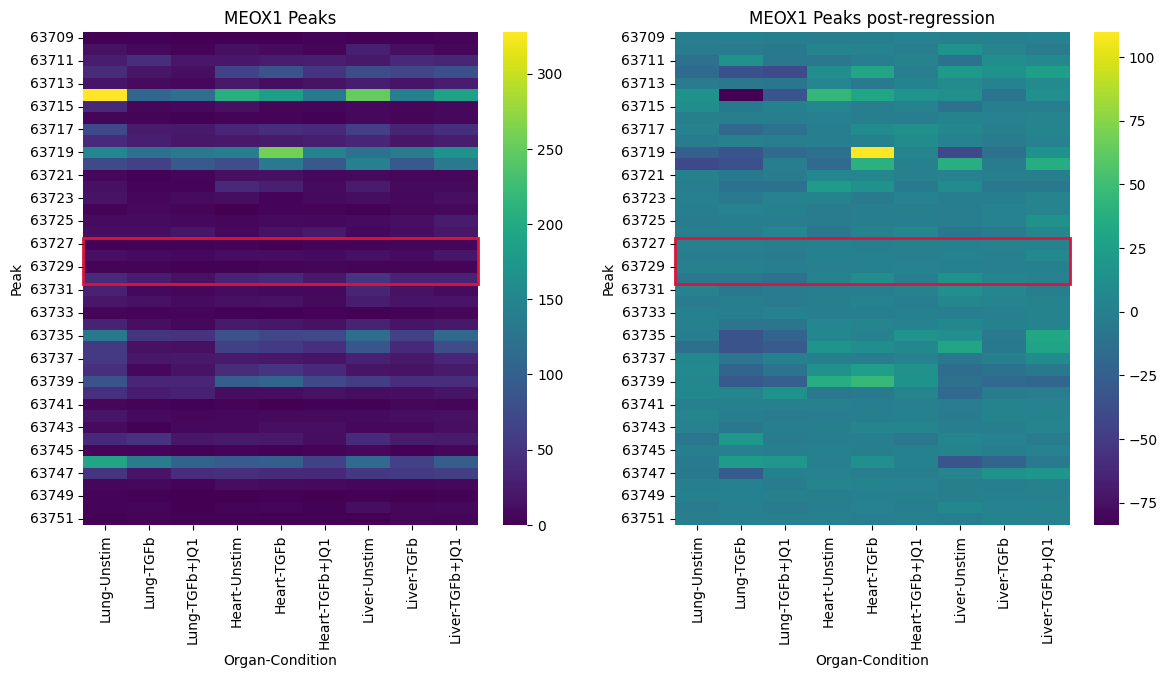

In [247]:
# MEOX1 peaks (Location according to UCSC is chr17, 43.64 - 43.66 Mb, expanding 150kb on either end)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 6.4))
plot_peak_range(atac_adata, gene='MEOX1', ax=ax1)
ax1.set_title("MEOX1 Peaks")
plot_peak_range(atac_adata, gene='MEOX1', ax=ax2, layer='post-regression')
ax2.set_title("MEOX1 Peaks post-regression")
plt.show()

In [12]:
# chr17:43,616,437-43,616,691 <- orthologous to mouse peak 5
# chr17:43,616,835-43,617,184 <- orthologous to mouse peak 5
# not captured in this data
atac_adata[:, ['63723', '63724']].var

,Chr,Start,End,Strand,Length
Peak,,,,,
63723,chr17,43614858,43615602,+,745
63724,chr17,43622133,43622721,+,589


In [13]:
# chr17:43,591,770-43,592,120 <- orthologous to mouse peak 10
# chr17:43,592,215-43,592,517 <- orthologous to mouse peak 9
# 63720 seems to bridge both of these intervals
atac_adata[:, '63720'].var

,Chr,Start,End,Strand,Length
Peak,,,,,
63720,chr17,43591191,43592816,+,1626


In [14]:
# chr17:43,577,707-43,577,887 <- orthologous to mouse peak 13
# chr17:43,578,079-43,578,427 <- orthologous to mouse peak 13
# chr17:43,578,441-43,578,702 <- orthologous to mouse peak 13
# regions seem to be directly flanking
atac_adata[:, ['63718', '63719']].var

,Chr,Start,End,Strand,Length
Peak,,,,,
63718,chr17,43576650,43577072,+,423
63719,chr17,43578751,43580003,+,1253


In [15]:
# boxplot of peak over organ/condition
def plot_peak(adata: ad.AnnData, peak: str, layer: str = None, **kwargs) -> plt.Axes:
  ax = sns.boxplot(adata.obs, x = 'organ', y = adata[:, peak].to_df(layer = layer).sum(axis = 1), order=markers.keys(), hue = 'condition', palette=palette, hue_order = palette.keys(), **kwargs)
  ax.set_ylabel(f'{peak} consensus peaks {layer if layer is not None else ""}')
  return ax

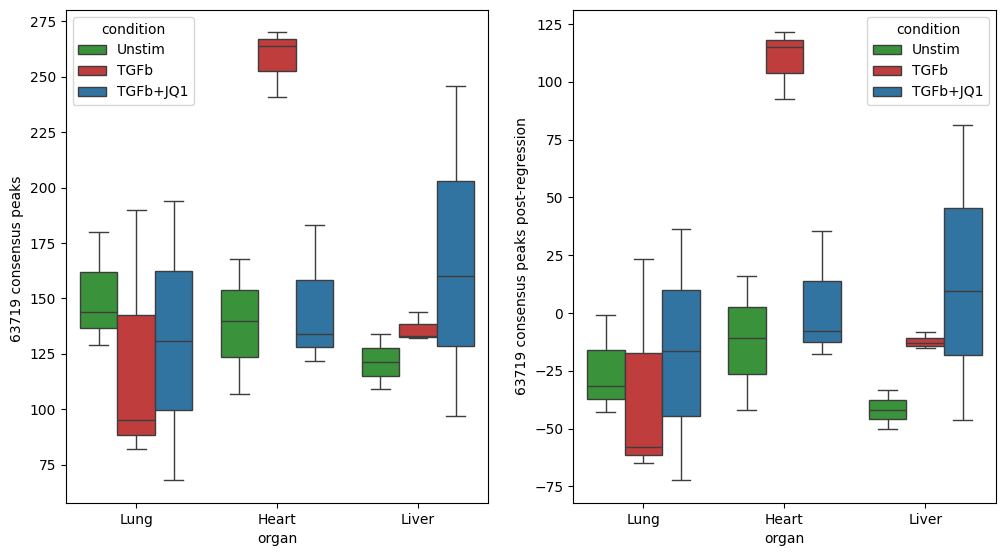

In [16]:
# Meox1 peaks
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_peak(atac_adata, peak = '63719', ax=ax1)
plot_peak(atac_adata, peak = '63719', ax=ax2, layer = 'post-regression')
plt.show()

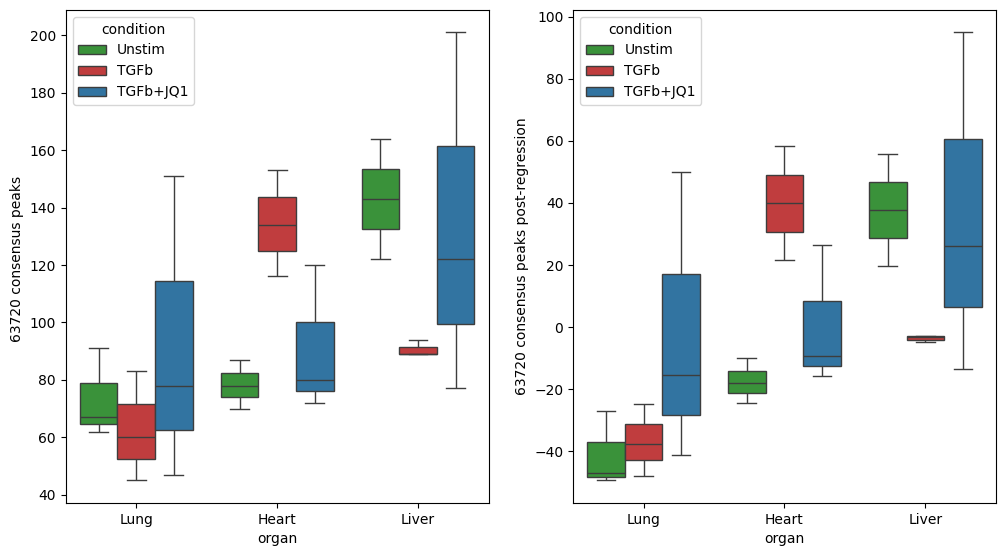

In [17]:
# Meox1 peaks
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_peak(atac_adata, peak = '63720', ax=ax1)
plot_peak(atac_adata, peak = '63720', ax=ax2, layer = 'post-regression')
plt.show()

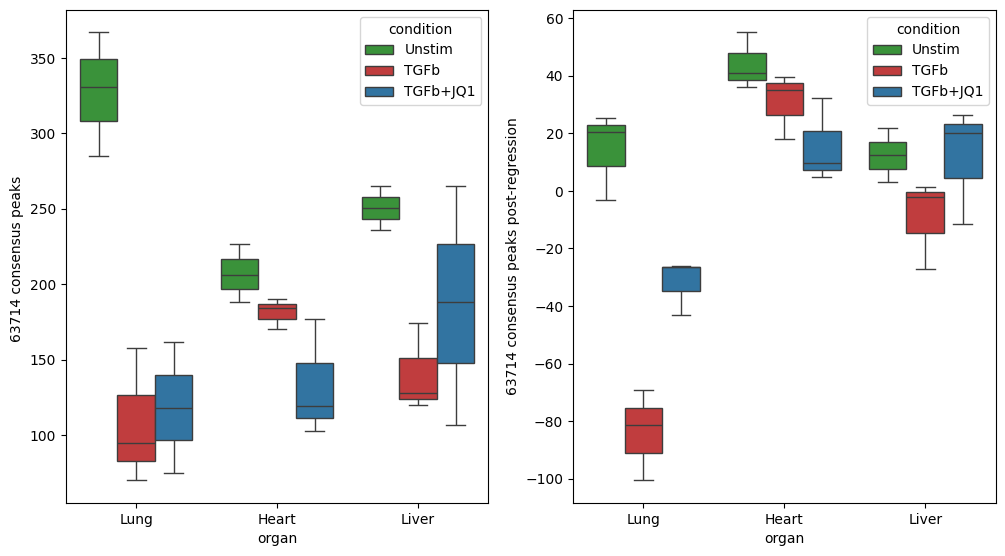

In [18]:
# Meox1 peaks
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_peak(atac_adata, peak = '63714', ax=ax1)
plot_peak(atac_adata, peak = '63714', ax=ax2, layer = 'post-regression')
plt.show()

### Methodology for identifying interesting peak-gene pairs
1. In one organ, identify genes with increased expression in TGFb and reduced in Unstim/JQ1.
2. For each gene, look within 150kb of TSS and identify peaks that show the same pattern across conditions.
3. Repeat steps 1 and 2 for each organ.
4. Compare/contrast peak-gene pairs across organs.
    - Can we identify organ-specific genes/enhancers?
    - Can we identify shared genes/enhancers?

Start by deep diving on heart!

In [19]:
def calc_condition_gene_averages(adata: ad.AnnData, organ: str, layer: str = None) -> pd.DataFrame:
  organ_adata = adata[adata.obs['organ'] == organ, :]
  organ_df = organ_adata.to_df(layer = layer)
  organ_df['condition'] = organ_adata.obs['condition']
  condition_avg_df = organ_df.groupby('condition', observed = False).aggregate('mean').T  # Average across replicates
  condition_avg_df['gene'] = organ_adata.var['gene']
  return condition_avg_df.groupby('gene', observed = False).aggregate('sum')  # Sum across gene variants

### Condition Sensitivity Scores
Scores calculated by the following formula (sign-adjusted by t_i):
$$c_i = \log_2 \left(\frac{\bar x_1 + \bar x_2 + \bar x_3}{3}\right) * \log_2 \left(\frac{\bar x_2}{\bar x_1}\right) * \log_2 \left(\frac{\bar x_3}{\bar x_2}\right)*t_i$$

- $x_1$: Unstim
- $x_2$: TGFb
- $x_3$: JQ1

Performed for both RNA and ATAC data. All values +1 to avoid divide by 0 and sign issues

> Each peak and each gene were independently assigned a condition sensitivity score for each organ (ci). This was calculated from the product of the log fold changes across each condition (x1 to x2 to x3), the mean across conditions, and a sign correction factor based on the desired trend directionality (ti). All data points used were means across replicates, with 1 added to ensure sign consistency with logarithmic scaling. This scoring methodology is easily extensible to more conditions and different trends, by including more log-fold changes and modifying the signs within ti, respectively. In the case of organ fibrosis, we want to see an increase in expression or accessibility between x1 (unstimulated) and x2 (TGF-β) and a decrease between x2 and x3 (JQ1), represented by the positive and negative coefficients in ti. The formula emphasizes genes and peaks with high expression and accessibility across all conditions, to reduce the impact of noise on score. The formula also places equal importance on both log-fold changes across conditions, prioritizing genes and peaks with moderate dynamic changes across conditions over genes and peaks with one high and one low change.


In [183]:
def calc_condition_sensitivity(organ_df: pd.DataFrame) -> pd.DataFrame:
  """Uses log fold change to determine which genes are up- and down-regulated in each condition"""
  odf_copy = organ_df + 1
  lfc_df = pd.DataFrame({
    'up': np.sqrt(np.log2(odf_copy.mean(axis = 1))) * np.log2(odf_copy['TGFb'] / odf_copy['Unstim']),
    'down': np.sqrt(np.log2(odf_copy.mean(axis = 1))) * np.log2(odf_copy['TGFb+JQ1'] / odf_copy['TGFb']),
  })
  t = np.sign(np.sign(odf_copy['Unstim'] - odf_copy['TGFb']) - np.sign(odf_copy['TGFb'] - odf_copy['TGFb+JQ1']))
  lfc_df['score'] = lfc_df['up'] * lfc_df['down'] * t
  return lfc_df

In [184]:
def find_organ_genes(organ_df: pd.DataFrame, up_by: int = 0, down_by: int = 0) -> list[str]:
  """Uses log fold change to determine which genes are up- and down-regulated in each condition"""
  upreg_genes = organ_df.index[(np.log2(organ_df['TGFb'] / organ_df['Unstim']) > up_by) & (np.log2(organ_df['TGFb+JQ1'] / organ_df['TGFb']) < down_by)]
  return upreg_genes

In [185]:
heart_rna_df = calc_condition_gene_averages(rna_adata, "Heart")
heart_rna_df.head()

condition,TGFb,TGFb+JQ1,Unstim
gene,,,
A1BG,1.130977,0.974347,1.287053
A1BG-AS1,1.837193,3.606701,1.548569
A1CF,0.001390,0.001376,0.000000
A2M,0.021714,0.005007,0.036045
A2M-AS1,0.107994,0.023121,0.074854


In [186]:
heart_gene_lfc_df = calc_condition_sensitivity(heart_rna_df)
heart_gene_lfc_df.head()

,up,down,score
gene,,,
A1BG,-0.106532,-1.150626e-01,0.000000e+00
A1BG-AS1,0.203923,9.213071e-01,0.000000e+00
A1CF,0.000073,-7.485525e-07,5.469442e-11
A2M,-0.003473,-4.111016e-03,0.000000e+00
A2M-AS1,0.013559,-3.558559e-02,4.825137e-04


In [187]:
def plot_lfc(lfc_df: pd.DataFrame, label: bool = False, **kwargs) -> plt.Axes:
  hnorm = hue_norm()
  if 'hue' not in kwargs:
    kwargs['hue'] = 'score'
    kwargs['palette'] = diverging_palette
    kwargs['hue_norm'] = hnorm
  ax = sns.scatterplot(lfc_df, x = 'up', y = 'down', legend=None, **kwargs)
  if label:
    for (idx, point) in lfc_df.iterrows():
      plt.text(point['up'], point['down'], idx, size='small')
  plt.xlabel("LFC(add TGFb)")
  plt.ylabel("LFC(add JQ1)")
  plt.axhline(0, linestyle='--', color = "lightgray")
  plt.axvline(0, linestyle='--', color = "lightgray")
  plt.autoscale(False)
  if type(kwargs['hue']) == str and kwargs['hue'] == 'score':
    legend_ax = ax.figure.add_axes((0.93, 0.15, 0.02, 0.7))
    legend_ax.figure.colorbar(sm(hnorm), cax=legend_ax)
  return ax

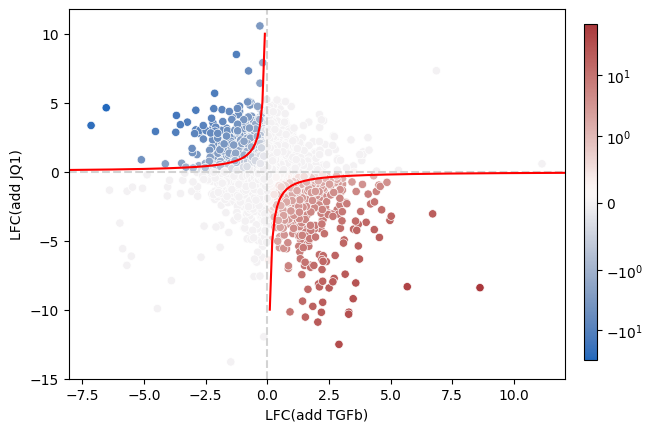

In [188]:
x = np.linspace(-100, 100, 2001)
with np.errstate(divide='ignore', invalid='ignore'):
  y = 1 / -x

ax = plot_lfc(heart_gene_lfc_df)
ax.plot(x, y, color = "red")
plt.show()

In [189]:
heart_rna_df.loc[['POSTN', 'MEOX1']]

condition,TGFb,TGFb+JQ1,Unstim
gene,,,
POSTN,162.404112,9.646059,126.615900
MEOX1,15.216120,0.173933,2.444118


In [190]:
heart_gene_lfc_df['score'][['POSTN', 'MEOX1']]

gene
POSTN     9.346945
MEOX1    23.673137
Name: score, dtype: float64

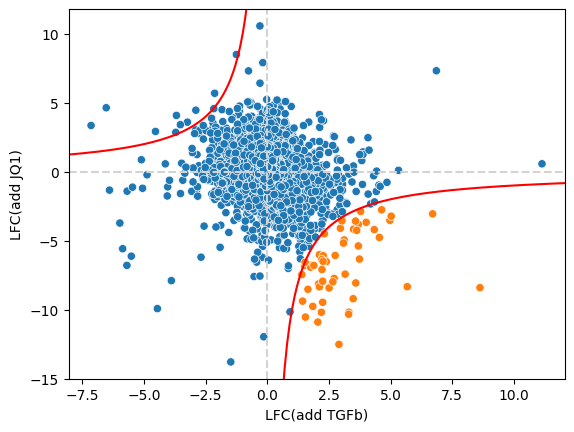

In [191]:
with np.errstate(divide='ignore', invalid='ignore'):
  y = 10 / -x

ax = plot_lfc(heart_gene_lfc_df, hue = heart_gene_lfc_df['score'] > 10)
ax.plot(x, y, color = "red")
plt.show()

In [192]:
def calc_condition_peak_averages(adata: ad.AnnData, organ: str, layer: str = None) -> pd.DataFrame:
  organ_adata = adata[adata.obs['organ'] == organ, :]
  organ_df = organ_adata.to_df(layer = layer)
  organ_df['condition'] = organ_adata.obs['condition']
  return organ_df.groupby('condition', observed = False).aggregate('mean').T  # Average across replicates

In [193]:
heart_atac_df = calc_condition_peak_averages(atac_adata, "Heart")

In [196]:
def peaks_for_good_genes(gene_lfc_df: pd.DataFrame, avg_peak_df: pd.DataFrame) -> dict[str, pd.DataFrame]:
  gene_to_peaks = {}
  for gene in gene_lfc_df.index:
    if not any(gene_locations['Symbol'] == gene):
      continue
    if sum(gene_locations['Symbol'] == gene) > 1:
      print(gene_locations.loc[gene_locations['Symbol'] == gene])
      continue
    chr, begin, end = gene_locations.loc[gene_locations['Symbol'] == gene][['Chromosome', 'Begin', 'End']].to_numpy().flatten()
    # chr, begin, end = row['Chromosome'], row['Begin'], row['End']
    peak_locs = atac_adata.var_names[
                                  (atac_adata.var['Chr'] == f'chr{chr}') & 
                                  (atac_adata.var['End'] >= begin - 1.5 * 10 ** 5) & 
                                  (atac_adata.var['Start'] <= end + 1.5 * 10 ** 5)]
    gene_subset_df = avg_peak_df.loc[peak_locs]
    peak_lfc_df = calc_condition_sensitivity(gene_subset_df)
    gene_to_peaks[gene] = peak_lfc_df
  return gene_to_peaks

In [197]:
heart_peak_df = calc_condition_sensitivity(heart_atac_df)

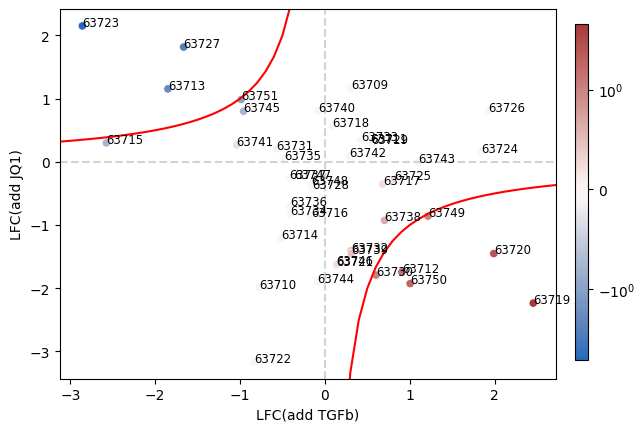

In [198]:
with np.errstate(divide='ignore', invalid='ignore'):
  y = 1 / -x

ax = plot_lfc(heart_peak_df.loc[gene_to_peaks_map['MEOX1']], label = True)
ax.plot(x, y, color = "red")
plt.show()

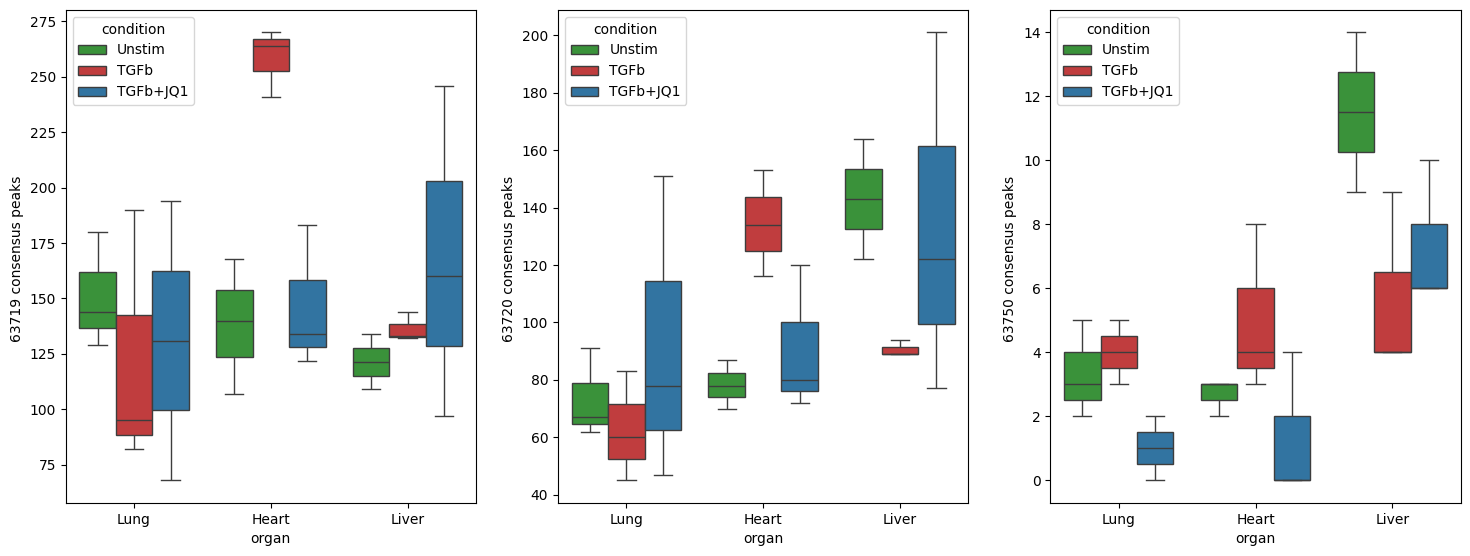

In [199]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 6.4))
plot_peak(atac_adata, peak = '63719', ax=ax1)
plot_peak(atac_adata, peak = '63720', ax=ax2)
plot_peak(atac_adata, peak = '63750', ax=ax3)
plt.show()

In [200]:
def merge_gene_peak_lfc(gene_lfc_df: pd.DataFrame, peak_lfc_df: pd.DataFrame) -> pd.DataFrame:
  gene_peak_pair_df = pd.DataFrame({(gene, peak): {'gene_score': gene_lfc_df['score'][gene], 'peak_score':peak_lfc_df['score'][peak]} for gene, peaks in gene_to_peaks_map.items() for peak in peaks}).T
  gene_peak_pair_df.index.names = ['Gene', 'Peak']
  gene_peak_pair_df = gene_peak_pair_df.sort_values(['gene_score', 'peak_score'], ascending=False)
  return gene_peak_pair_df

In [201]:
def get_best_pg_pairs(gene_peak_pair_df: pd.DataFrame, n = 10) -> list[tuple[str, str]]:
  ordered_pairs = (gene_peak_pair_df.T.agg('prod') * (np.sign(gene_peak_pair_df['peak_score']) + np.sign(gene_peak_pair_df['gene_score'])) - 1).T.sort_values(ascending=False)
  top_genes = ordered_pairs.index.get_level_values(0).unique()[0:n]
  top_pairs = ordered_pairs.groupby(level=0).nth(0).loc[top_genes].index
  return top_pairs

In [202]:
heart_gene_peak_pair_df = merge_gene_peak_lfc(heart_gene_lfc_df, heart_peak_df)
best_heart_peaks = get_best_pg_pairs(heart_gene_peak_pair_df)

In [203]:
def plot_pg_pairs(gene_peak_pair_df: pd.DataFrame, best_peaks: list[tuple[str, str]] = [], **kwargs) -> plt.Axes: 
  plot_args = {
    **kwargs
  }
  if len(best_peaks) > 0:
    plot_args['hue'] = gene_peak_pair_df.index.isin(best_peaks)
  ax = sns.scatterplot(gene_peak_pair_df, x = 'gene_score', y = 'peak_score', legend = None, **plot_args)
  for (gene, peak) in best_peaks:
    point = gene_peak_pair_df.loc[(gene, peak)]
    ax.text(point['gene_score'], point['peak_score'], f'{gene}-{peak}', size='x-small', va='bottom')
  return ax

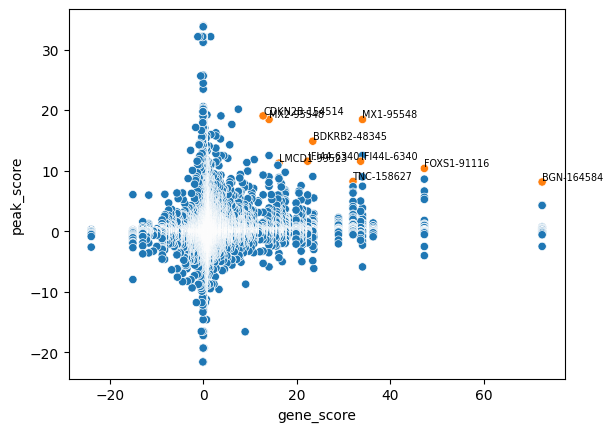

In [204]:
plot_pg_pairs(heart_gene_peak_pair_df, best_heart_peaks)
plt.show()

### Combining across organs

In [205]:
def run_organ_analysis(organ: str, layer: str = None) -> pd.DataFrame:
  organ_rna_df = calc_condition_gene_averages(rna_adata, organ, layer = layer)
  organ_gene_lfc_df = calc_condition_sensitivity(organ_rna_df)
  organ_atac_df = calc_condition_peak_averages(atac_adata, organ, layer = layer)
  organ_peak_lfc_df = calc_condition_sensitivity(organ_atac_df)
  organ_gene_peak_pair_df = merge_gene_peak_lfc(organ_gene_lfc_df, organ_peak_lfc_df)
  return organ_gene_peak_pair_df

In [206]:
organ_to_all_pg_pairs = {
  organ: run_organ_analysis(organ) for organ in markers.keys()
}

In [207]:
organ_to_best_sensitivity_pairs = {
  organ: get_best_pg_pairs(organ_to_all_pg_pairs[organ]) for organ in markers.keys()
}

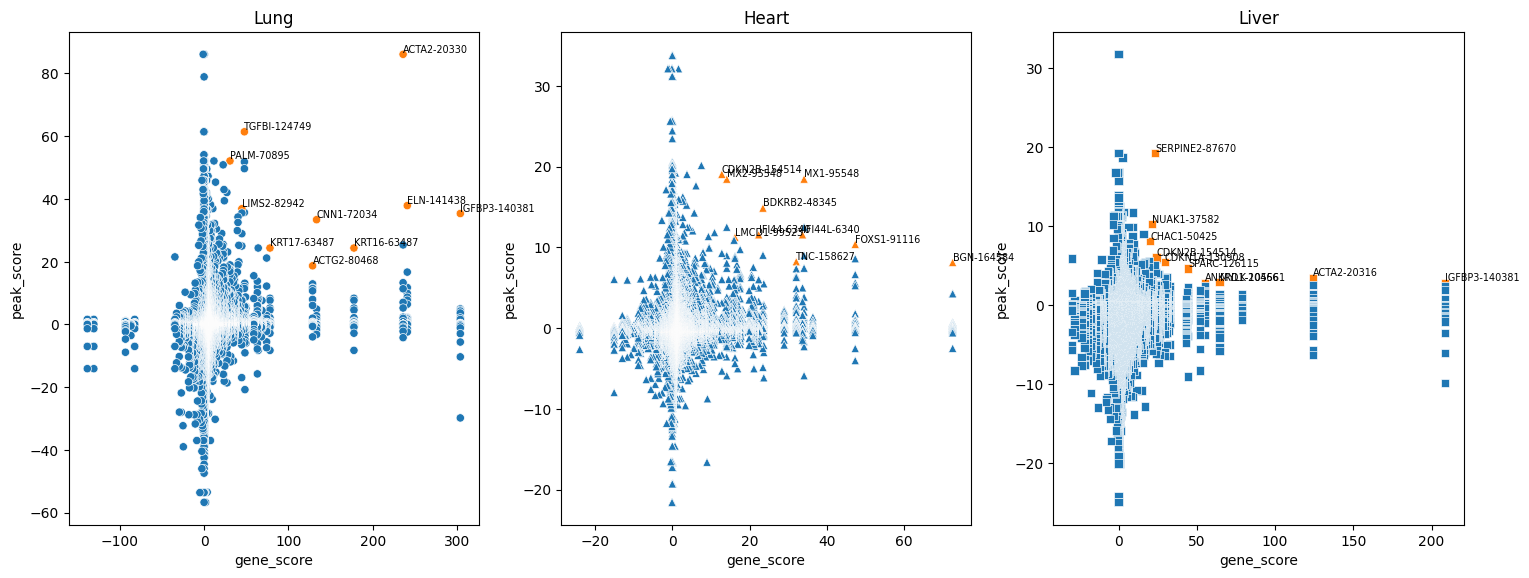

In [208]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6.4))
for (ax, organ) in zip(axs, markers.keys()):
  plot_pg_pairs(organ_to_all_pg_pairs[organ], organ_to_best_sensitivity_pairs[organ], ax=ax, marker=markers[organ])
  ax.set_title(organ)
plt.show()

In [209]:
combined_score_df = pd.concat(organ_to_all_pg_pairs.values(), axis = 'columns', keys = organ_to_all_pg_pairs.keys())
combined_score_df = combined_score_df.fillna(0.)
combined_score_df.to_csv('./data/pg_pairs_raw.csv')
combined_score_df

Lung                 Heart                  Liver  \
               gene_score peak_score gene_score peak_score  gene_score   
Gene   Peak                                                              
IGFBP3 140381  303.596298  35.335848   1.559546   0.000000  208.559236   
       140389  303.596298   4.941446   1.559546   0.544415  208.559236   
       140392  303.596298   4.516195   1.559546   0.000000  208.559236   
       140394  303.596298   4.220600   1.559546   0.164744  208.559236   
       140391  303.596298   3.614890   1.559546   0.459782  208.559236   
...                   ...        ...        ...        ...         ...   
MT2A   57900  -138.362206   0.000000   0.000000   0.948960  -23.688266   
       57893  -138.362206  -1.389506   0.000000  -2.411596  -23.688266   
       57882  -138.362206  -6.991253   0.000000   0.000000  -23.688266   
       57876  -138.362206  -7.037122   0.000000  -1.759782  -23.688266   
       57883  -138.362206 -14.135121   0.000000   1.067576  -23.688266   

                          
              peak_score  
Gene   Peak               
IGFBP3 140381   2.806273  
       140389   2.377671  
       140392   0.000000  
       140394   0.772570  
       140391   0.000000  
...                  ...  
MT2A   57900   -1.942576  
       57893    0.000000  
       57882   -3.711087  
       57876   -6.620992  
       57883   -0.077276  

[613480 rows x 6 columns]

In [210]:
pairs_in_all = combined_score_df[~combined_score_df.lt(5.0).any(axis=1)].index

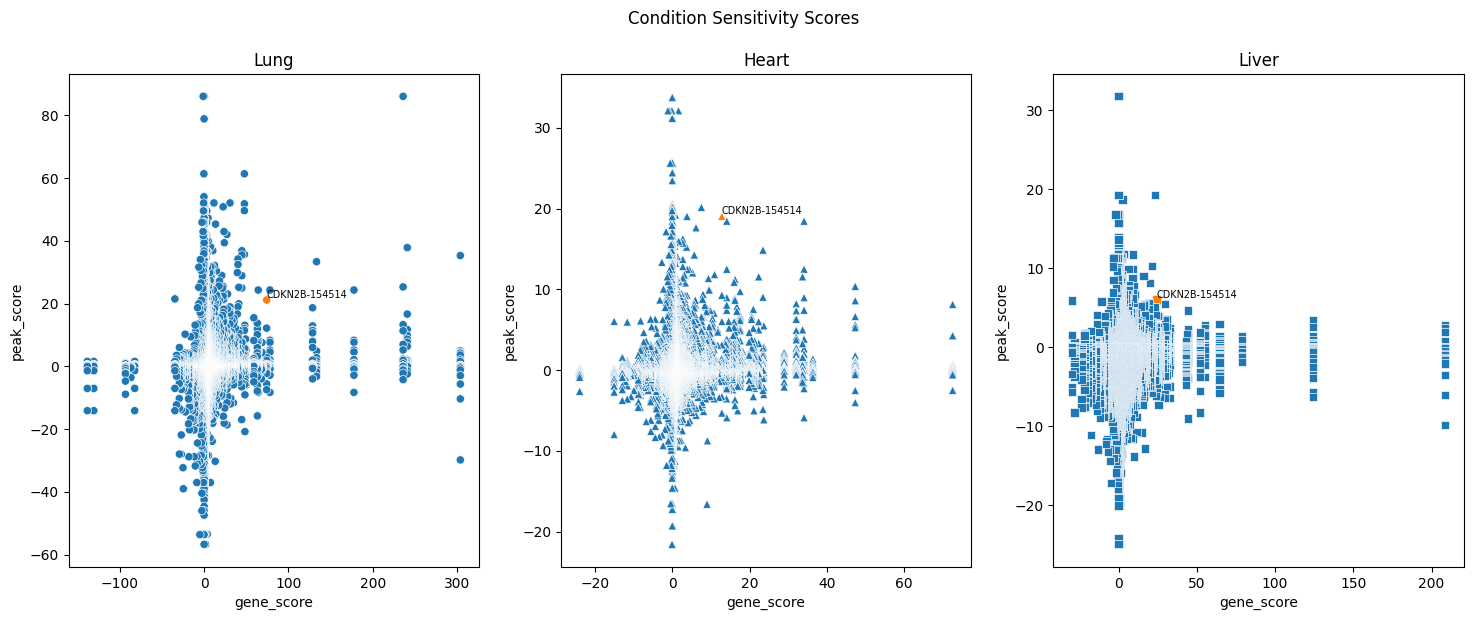

In [211]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6.4))
for (ax, organ) in zip(axs, markers.keys()):
  plot_pg_pairs(organ_to_all_pg_pairs[organ], pairs_in_all, ax=ax, marker=markers[organ])
  ax.set_title(organ)
fig.suptitle("Condition Sensitivity Scores")
plt.show()

### Organ Specificity Scoring

Above approach is a bit arbitrary... Let's instead calculate organ specificity scores for each peak and each gene.

Scores will be scaled to 0 to 1 for each datapoint. Maybe logarithmically instead of linearly?

$$o_i = c_i - \bar c_j$$

> To compare scores across organs, the condition sensitivity scores were each linearly normalized to the range [0, 1], with negative scores clamped to 0. Organ specificity scores were calculated for each organ by subtracting the condition sensitivity score for that organ from the mean of condition sensitivity scores from all other organs. This results in organ specificity scores ranging from [-1, 1]. A positive score indicates that a peak or gene is more specific for the given organ than others, while a negative score indicates the gene or peak is less specific to the organ than others. All organ specificity scores for a given gene or peak will sum to 0.

In [212]:
sensitivity_df = combined_score_df / combined_score_df.max()
sensitivity_df = sensitivity_df.where(sensitivity_df > 0., 0.)
sensitivity_df.to_csv('./data/pg_pairs_sensitivity.csv')
sensitivity_df.head()

Lung                 Heart                 Liver  \
              gene_score peak_score gene_score peak_score gene_score   
Gene   Peak                                                            
IGFBP3 140381        1.0   0.410406   0.021499   0.000000        1.0   
       140389        1.0   0.057392   0.021499   0.016061        1.0   
       140392        1.0   0.052453   0.021499   0.000000        1.0   
       140394        1.0   0.049020   0.021499   0.004860        1.0   
       140391        1.0   0.041985   0.021499   0.013564        1.0   

                          
              peak_score  
Gene   Peak               
IGFBP3 140381   0.088449  
       140389   0.074941  
       140392   0.000000  
       140394   0.024350  
       140391   0.000000

In [213]:
sums = sensitivity_df.T.groupby(level = 1).agg('sum').T
norgans = sensitivity_df.columns.get_level_values(0).unique().size
specificity_df = sensitivity_df.apply(lambda col: col - (sums[col.name[1]] - col) / (norgans - 1), axis = 0)
specificity_df = specificity_df.sort_values(list(specificity_df.columns), ascending=False)
specificity_df.to_csv('./data/pg_pairs_specificity.csv')
specificity_df.head()

Lung                 Heart                 Liver           
            gene_score peak_score gene_score peak_score gene_score peak_score
Gene Peak                                                                    
ELN  141438    0.74336   0.439731  -0.446144  -0.219865  -0.297216  -0.219865
     141448    0.74336   0.193516  -0.446144  -0.096758  -0.297216  -0.096758
     141434    0.74336   0.136330  -0.446144  -0.068165  -0.297216  -0.068165
     141433    0.74336   0.114734  -0.446144  -0.057367  -0.297216  -0.057367
     141429    0.74336   0.084135  -0.446144  -0.034031  -0.297216  -0.050104

In [214]:
organ_to_best_specificity_pairs = {
  organ: get_best_pg_pairs(specificity_df[organ]) for organ in markers.keys()
}

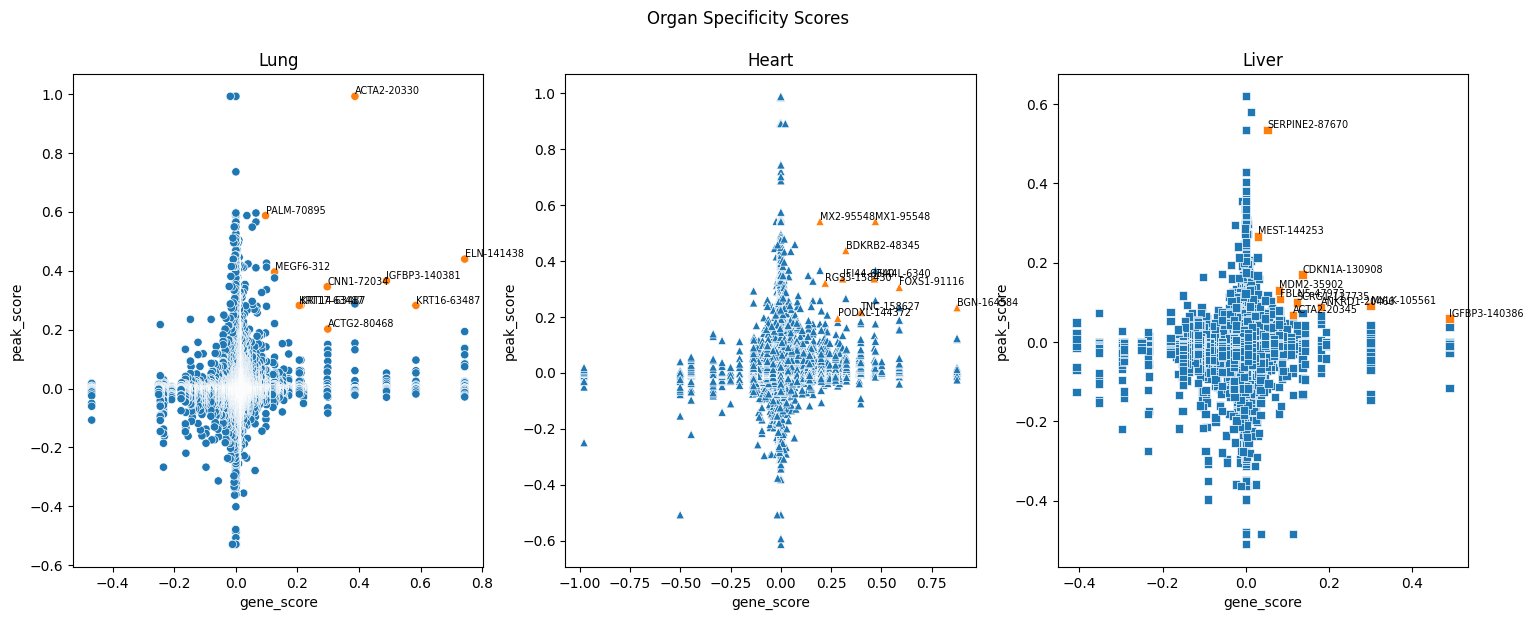

In [215]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6.4))
for (ax, organ) in zip(axs, markers.keys()):
  plot_pg_pairs(specificity_df[organ], organ_to_best_specificity_pairs[organ], ax=ax, marker=markers[organ])
  ax.set_title(organ)
fig.suptitle("Organ Specificity Scores")
plt.show()

<Axes: xlabel='organ', ylabel='141438 consensus peaks '>

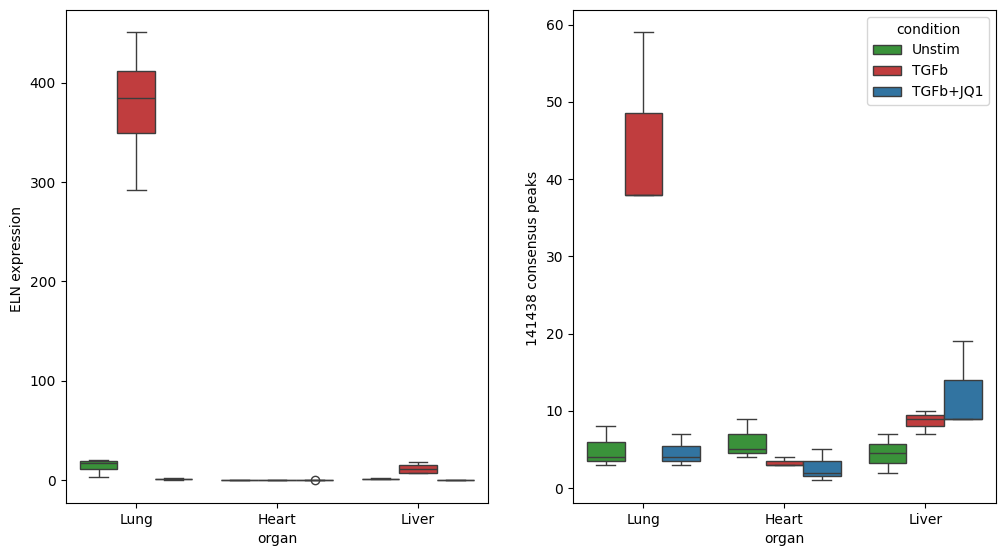

In [216]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_expression(rna_adata, 'ELN', ax=ax1, legend=False)
plot_peak(atac_adata, '141438', ax=ax2)

### Universality Scoring

$$u = \left(1 - \frac{1}{n}\sum |o|\right) * \bar c$$

> The final score calculated for each gene and peak was a universality score. This formula relies on all organ specificity and condition sensitivity scores, and gives a higher score to genes and peaks that minimize average absolute organ specificity with high condition sensitivity across organs. Scores can lie in the range [0, 1], with a higher score indicating a more universal gene or peak. This formula can also be easily extended to different numbers of organs, indicated in the formula by n.

In [217]:
universal_df = (1 - specificity_df.abs().T.groupby(level = 1).agg('mean').T) * (sensitivity_df.T.groupby(level = 1).agg('mean').T)
universal_df.to_csv('./data/pg_pairs_universality.csv')
universal_df.head()

gene_score  peak_score
Gene Peak                         
A1BG 75666    0.000722    0.017615
     75667    0.000722    0.000000
     75668    0.000722    0.005873
     75669    0.000722    0.001729
     75670    0.000722    0.000413

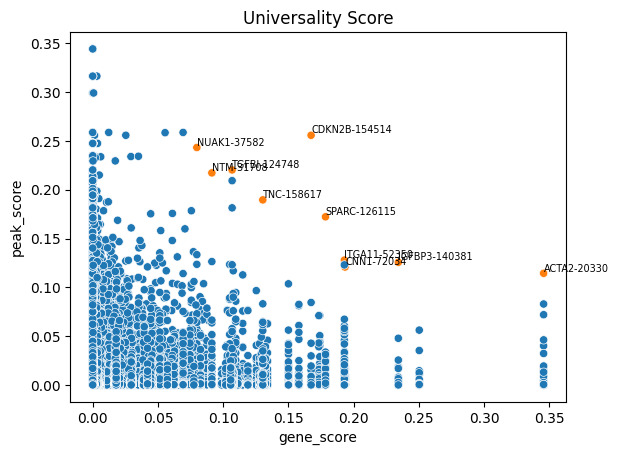

In [218]:
top_universal_pairs = get_best_pg_pairs(universal_df)
ax = plot_pg_pairs(universal_df, top_universal_pairs)
ax.set_title('Universality Score')
plt.show()

<Axes: xlabel='organ', ylabel='20330 consensus peaks '>

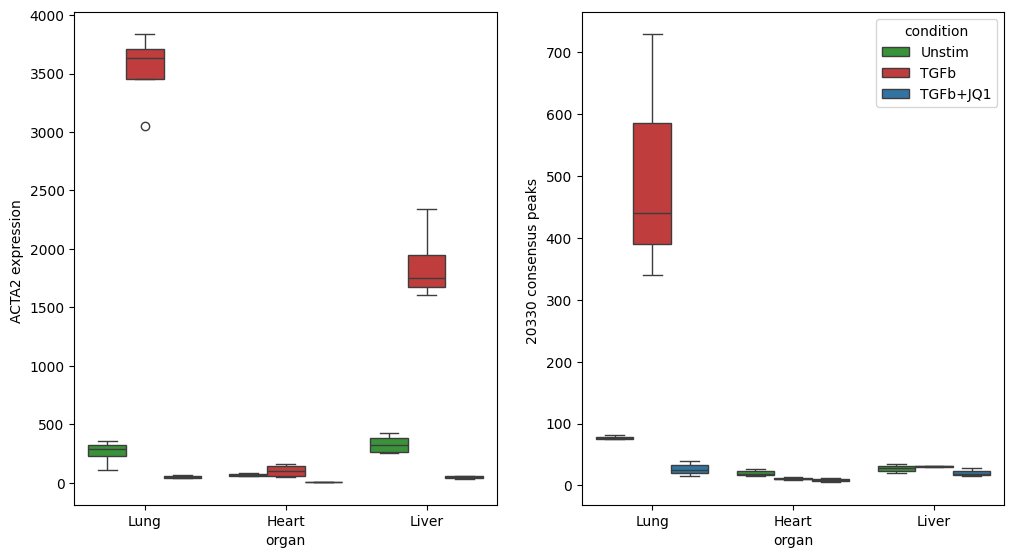

In [219]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_expression(rna_adata, 'ACTA2', ax=ax1, legend=False)
plot_peak(atac_adata, '20330', ax=ax2)

/scratch/ipykernel_2875337/1623660810.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (organ, condition), rows in peak_adata.obs.groupby(['organ', 'condition'])


<Axes: title={'center': 'Peaks around ACTA2'}, xlabel='Organ-Condition', ylabel='Peak'>

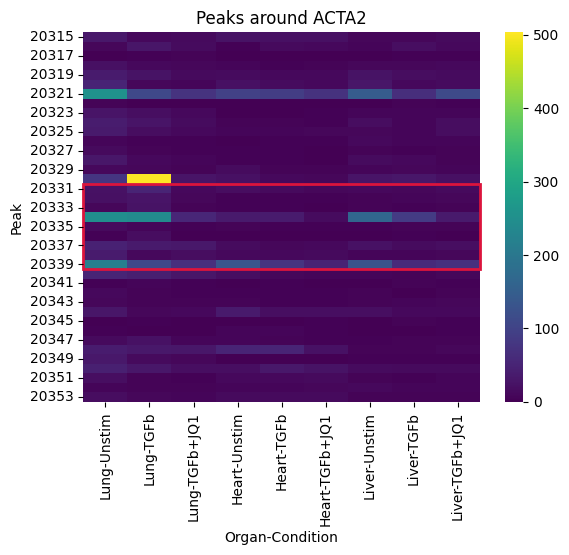

In [249]:
plot_peak_range(atac_adata, gene = 'ACTA2')

In [220]:
sensitivity_df.loc['ACTA2', '20330']

Lung   gene_score    0.776683
       peak_score    1.000000
Heart  gene_score    0.185017
       peak_score    0.000000
Liver  gene_score    0.594816
       peak_score    0.014695
Name: (ACTA2, 20330), dtype: float64

In [221]:
specificity_df.loc['ACTA2', '20330']

Lung   gene_score    0.386767
       peak_score    0.992652
Heart  gene_score   -0.500732
       peak_score   -0.507348
Liver  gene_score    0.113965
       peak_score   -0.485305
Name: (ACTA2, 20330), dtype: float64

In [222]:
universal_df.loc['ACTA2', '20330']

gene_score    0.345639
peak_score    0.114401
Name: (ACTA2, 20330), dtype: float64

<Axes: xlabel='organ', ylabel='154514 consensus peaks '>

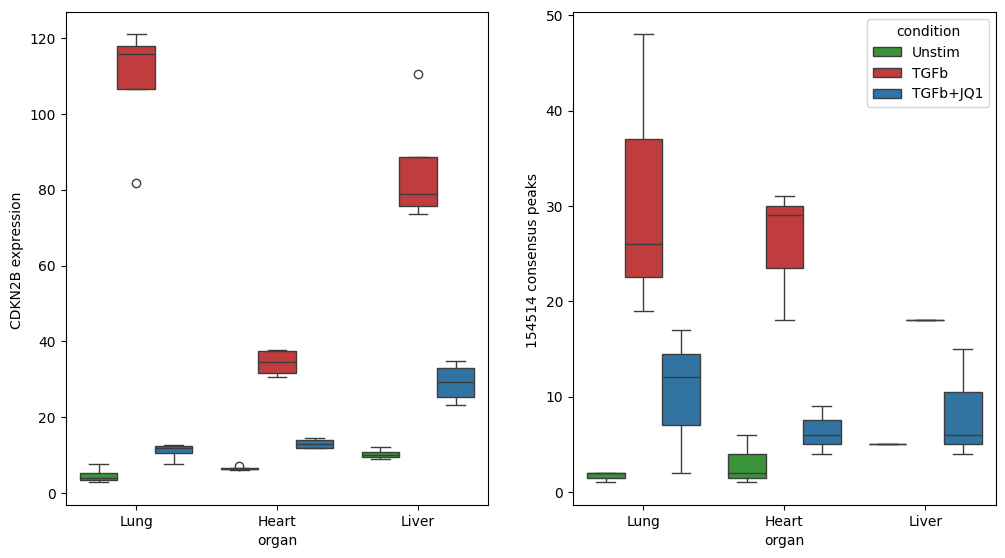

In [223]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_expression(rna_adata, 'CDKN2B', ax=ax1, legend=False)
plot_peak(atac_adata, '154514', ax=ax2)

### Determine Gene Functions

Cross-reference genes with [PantherDB](https://pantherdb.org/)/Gene Ontology to determine gene functional enrichment.

Cross-reference peaks with [Screen 2.0](https://screen.wenglab.org/) to determine previously identified cCREs. Ask Pawel - any recommendation for database to search for functional annotations of these cCREs?

In [224]:
def functional_enrichment(gene_list: list[str]):
  query = {
    'organism': 9606,  # human
    'annotDataSet': 'GO:0008150',  # gene ontology for biological processes
    'geneInputList': ','.join(gene_list)
  }
  request = requests.post(
    "https://pantherdb.org/services/oai/pantherdb/enrich/overrep", 
    params=query
  )
  if request.status_code != 200:
      raise Exception("Query failed. Status code: {}.".format(request.status_code))
  result = request.json()
  enriched_functions = result['results']['result']
  return [(func['term']['label'], func['pValue']) for func in enriched_functions if func['pValue'] < 0.001]

In [225]:
def get_screen_cCREs(peak_list: pd.DataFrame):
  variables = {
    "coordinates": [{ "chromosome": row['Chr'], "start": row["Start"], "end": row["End"] } for _idx, row in peak_list.iterrows()],
    "assembly": "grch38"
  }
  query = """
  query cCRESCREENSearch($assembly: String!, $coordinates: [GenomicRangeInput], ) { 
    cCRESCREENSearch(assembly: $assembly, coordinates: $coordinates) {
        info {
          accession
        }
        chrom
        start
        len
        pct     
        ctcf_zscore
        dnase_zscore
        atac_zscore
        enhancer_zscore
        promoter_zscore
      }
  }
  """
  request = requests.post(
      'https://factorbook.api.wenglab.org/graphql',
      json={ 'query': query, 'variables': variables },
      headers={}
  )
  if request.status_code != 200:
      raise Exception("Query failed. Status code: {}.".format(request.status_code))
  result = request.json()
  cCREs = sorted(result['data']['cCRESCREENSearch'], key = lambda cCRE: cCRE['enhancer_zscore'], reverse = True)
  return [(cCRE['info']['accession'], cCRE['enhancer_zscore']) for cCRE in cCREs if cCRE['enhancer_zscore'] > 3.1]

In [226]:
def get_functions_and_cCREs(pairs: list[tuple[str, str]]):
  functions = functional_enrichment([gene for gene, _peak in pairs])
  cCREs = get_screen_cCREs(atac_adata.var.loc[[peak for _gene, peak in pairs]])
  return functions, cCREs

In [227]:
common_functions, common_cCREs = get_functions_and_cCREs(pairs_in_all)

In [228]:
common_functions

[('cellular response to cell-matrix adhesion', 9.718172983865924e-05),
 ('negative regulation of glial cell proliferation', 0.0007774538386714931)]

In [229]:
common_cCREs

[('EH38E2687392', 4.366672515869141)]

In [230]:
for organ, pairs in organ_to_best_pairs.items():
  organ_functions, organ_cCREs = get_functions_and_cCREs(pairs)
  print(f'--- {organ:^10} ---')
  print(organ_functions)
  print(organ_cCREs)

---    Lung    ---
[('tissue migration', 9.390264411082205e-07), ('mesenchyme migration', 2.1234163155312577e-06), ('regulation of smooth muscle cell proliferation', 3.420302211199633e-05), ('tissue development', 6.199505739949213e-05), ('tissue morphogenesis', 0.0001092611390323547), ('supramolecular fiber organization', 0.00013831594223282425), ('cytoskeleton organization', 0.00017352675169231757), ('anatomical structure morphogenesis', 0.00023986489779125476), ('negative regulation of smooth muscle cell proliferation', 0.00024688161855579367), ('mesenchyme morphogenesis', 0.0003112664521003804), ('positive regulation of hepatic stellate cell contraction', 0.00048590864918232526), ('regulation of hepatic stellate cell contraction', 0.00048590864918232526), ('negative regulation of cholangiocyte proliferation', 0.00048590864918232526), ('intermediate filament organization', 0.0005941363146146209), ('keratinization', 0.0006912489311531609), ('animal organ development', 0.00093959514769